# Model training.

[Dataset](https://github.com/imesluh/vocalfolds)


In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from Uformer import modelPoolAndAtt
from losses import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 7
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 3e-4
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob('../../vocalfolds/img/*/*/*.png')
MASK_DATASET_PATH  = glob('../../vocalfolds/annot/*/*/*.png')

N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 536


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[0],[1],[2],[3],[4],[5],[6]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (0, 0, 0))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (NUM_CLASSES, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = modelPoolAndAtt.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=NUM_CLASSES, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

c:\Users\alexg\miniconda3\envs\pytorch-gpu\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 428 examples in the training set...
[INFO] found 108 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.CombinedLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE + 1
testSteps = len(testDS) // BATCH_SIZE + 1
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
bestIoU = 0
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	#torch.cuda.empty_cache()
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")
	
	if avgTestIoU > bestIoU:
		bestIoU = avgTestIoU
		torch.save(uformer.state_dict(), '../models/vf_uformerpoolandatt.pth')
		print('Best IoU improved. Model saved.')
		
# display the total time needed to perform the training 
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')

[INFO] training the network...


100%|██████████| 14/14 [00:07<00:00,  1.94it/s]


[INFO] EPOCH: 1/100
Train loss: 2.844404, Test loss: 2.8163, Train IoU: 0.1867, Test IoU: 0.2083, Train Dice: 0.2839, Test Dice: 0.3448
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 2/100
Train loss: 2.784279, Test loss: 2.7722, Train IoU: 0.2311, Test IoU: 0.2375, Train Dice: 0.3691, Test Dice: 0.3779
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


[INFO] EPOCH: 3/100
Train loss: 2.753412, Test loss: 2.7674, Train IoU: 0.2537, Test IoU: 0.2463, Train Dice: 0.3956, Test Dice: 0.3938
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 4/100
Train loss: 2.743717, Test loss: 2.7354, Train IoU: 0.2645, Test IoU: 0.2685, Train Dice: 0.4143, Test Dice: 0.4171
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


[INFO] EPOCH: 5/100
Train loss: 2.688162, Test loss: 2.6309, Train IoU: 0.3109, Test IoU: 0.3627, Train Dice: 0.4628, Test Dice: 0.5262
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


[INFO] EPOCH: 6/100
Train loss: 2.604027, Test loss: 2.6174, Train IoU: 0.3872, Test IoU: 0.3753, Train Dice: 0.5545, Test Dice: 0.5428
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


[INFO] EPOCH: 7/100
Train loss: 2.566728, Test loss: 2.5380, Train IoU: 0.4252, Test IoU: 0.4538, Train Dice: 0.5920, Test Dice: 0.6187
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 8/100
Train loss: 2.534650, Test loss: 2.5296, Train IoU: 0.4589, Test IoU: 0.4638, Train Dice: 0.6240, Test Dice: 0.6300
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 9/100
Train loss: 2.506802, Test loss: 2.4752, Train IoU: 0.4907, Test IoU: 0.5241, Train Dice: 0.6526, Test Dice: 0.6845
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 10/100
Train loss: 2.465316, Test loss: 2.4402, Train IoU: 0.5372, Test IoU: 0.5662, Train Dice: 0.6942, Test Dice: 0.7203
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 11/100
Train loss: 2.441834, Test loss: 2.4196, Train IoU: 0.5652, Test IoU: 0.5919, Train Dice: 0.7188, Test Dice: 0.7411
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 12/100
Train loss: 2.428151, Test loss: 2.3999, Train IoU: 0.5826, Test IoU: 0.6177, Train Dice: 0.7325, Test Dice: 0.7611
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 13/100
Train loss: 2.397427, Test loss: 2.3794, Train IoU: 0.6224, Test IoU: 0.6456, Train Dice: 0.7633, Test Dice: 0.7816
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 14/100
Train loss: 2.393268, Test loss: 2.3786, Train IoU: 0.6277, Test IoU: 0.6460, Train Dice: 0.7677, Test Dice: 0.7823
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 15/100
Train loss: 2.388023, Test loss: 2.3662, Train IoU: 0.6350, Test IoU: 0.6633, Train Dice: 0.7730, Test Dice: 0.7952
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 16/100
Train loss: 2.379083, Test loss: 2.3829, Train IoU: 0.6463, Test IoU: 0.6403, Train Dice: 0.7824, Test Dice: 0.7785


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 17/100
Train loss: 2.375343, Test loss: 2.3589, Train IoU: 0.6514, Test IoU: 0.6743, Train Dice: 0.7860, Test Dice: 0.8029
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 18/100
Train loss: 2.376004, Test loss: 2.3532, Train IoU: 0.6504, Test IoU: 0.6815, Train Dice: 0.7860, Test Dice: 0.8086
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 19/100
Train loss: 2.351510, Test loss: 2.3377, Train IoU: 0.6850, Test IoU: 0.7044, Train Dice: 0.8103, Test Dice: 0.8240
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 20/100
Train loss: 2.351780, Test loss: 2.3517, Train IoU: 0.6848, Test IoU: 0.6839, Train Dice: 0.8100, Test Dice: 0.8100


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 21/100
Train loss: 2.360219, Test loss: 2.3661, Train IoU: 0.6731, Test IoU: 0.6635, Train Dice: 0.8015, Test Dice: 0.7954


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 22/100
Train loss: 2.349247, Test loss: 2.3380, Train IoU: 0.6886, Test IoU: 0.7040, Train Dice: 0.8127, Test Dice: 0.8241


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 23/100
Train loss: 2.337555, Test loss: 2.3359, Train IoU: 0.7054, Test IoU: 0.7070, Train Dice: 0.8245, Test Dice: 0.8261
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 24/100
Train loss: 2.329320, Test loss: 2.3339, Train IoU: 0.7173, Test IoU: 0.7104, Train Dice: 0.8329, Test Dice: 0.8278
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 25/100
Train loss: 2.328695, Test loss: 2.3179, Train IoU: 0.7184, Test IoU: 0.7352, Train Dice: 0.8334, Test Dice: 0.8440
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 26/100
Train loss: 2.315586, Test loss: 2.3285, Train IoU: 0.7378, Test IoU: 0.7179, Train Dice: 0.8467, Test Dice: 0.8337


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 27/100
Train loss: 2.313457, Test loss: 2.3107, Train IoU: 0.7406, Test IoU: 0.7454, Train Dice: 0.8490, Test Dice: 0.8511
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


[INFO] EPOCH: 28/100
Train loss: 2.317672, Test loss: 2.3232, Train IoU: 0.7354, Test IoU: 0.7262, Train Dice: 0.8445, Test Dice: 0.8389


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 29/100
Train loss: 2.312029, Test loss: 2.3164, Train IoU: 0.7435, Test IoU: 0.7361, Train Dice: 0.8504, Test Dice: 0.8459


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 30/100
Train loss: 2.311347, Test loss: 2.3068, Train IoU: 0.7448, Test IoU: 0.7514, Train Dice: 0.8508, Test Dice: 0.8556
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 31/100
Train loss: 2.310695, Test loss: 2.3111, Train IoU: 0.7452, Test IoU: 0.7440, Train Dice: 0.8518, Test Dice: 0.8511


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 32/100
Train loss: 2.302176, Test loss: 2.3231, Train IoU: 0.7588, Test IoU: 0.7264, Train Dice: 0.8604, Test Dice: 0.8393


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 33/100
Train loss: 2.308143, Test loss: 2.2978, Train IoU: 0.7498, Test IoU: 0.7655, Train Dice: 0.8542, Test Dice: 0.8643
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 34/100
Train loss: 2.299079, Test loss: 2.2966, Train IoU: 0.7637, Test IoU: 0.7668, Train Dice: 0.8636, Test Dice: 0.8659
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 35/100
Train loss: 2.294870, Test loss: 2.3072, Train IoU: 0.7701, Test IoU: 0.7503, Train Dice: 0.8678, Test Dice: 0.8552


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 36/100
Train loss: 2.289552, Test loss: 2.3000, Train IoU: 0.7788, Test IoU: 0.7612, Train Dice: 0.8731, Test Dice: 0.8622


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 37/100
Train loss: 2.296086, Test loss: 2.3122, Train IoU: 0.7681, Test IoU: 0.7431, Train Dice: 0.8665, Test Dice: 0.8502


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 38/100
Train loss: 2.294237, Test loss: 2.2946, Train IoU: 0.7718, Test IoU: 0.7700, Train Dice: 0.8684, Test Dice: 0.8678
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 39/100
Train loss: 2.294638, Test loss: 2.2982, Train IoU: 0.7705, Test IoU: 0.7646, Train Dice: 0.8680, Test Dice: 0.8645


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 40/100
Train loss: 2.290349, Test loss: 2.2919, Train IoU: 0.7768, Test IoU: 0.7738, Train Dice: 0.8724, Test Dice: 0.8707
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 41/100
Train loss: 2.287455, Test loss: 2.2983, Train IoU: 0.7815, Test IoU: 0.7638, Train Dice: 0.8753, Test Dice: 0.8644


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 42/100
Train loss: 2.280869, Test loss: 2.2857, Train IoU: 0.7922, Test IoU: 0.7840, Train Dice: 0.8821, Test Dice: 0.8770
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 43/100
Train loss: 2.280053, Test loss: 2.2856, Train IoU: 0.7938, Test IoU: 0.7843, Train Dice: 0.8827, Test Dice: 0.8768
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 44/100
Train loss: 2.282695, Test loss: 2.2813, Train IoU: 0.7896, Test IoU: 0.7909, Train Dice: 0.8800, Test Dice: 0.8815
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 45/100
Train loss: 2.280752, Test loss: 2.2811, Train IoU: 0.7925, Test IoU: 0.7913, Train Dice: 0.8822, Test Dice: 0.8817
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 46/100
Train loss: 2.273400, Test loss: 2.2806, Train IoU: 0.8045, Test IoU: 0.7920, Train Dice: 0.8895, Test Dice: 0.8821
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.80it/s]


[INFO] EPOCH: 47/100
Train loss: 2.271715, Test loss: 2.2805, Train IoU: 0.8072, Test IoU: 0.7923, Train Dice: 0.8912, Test Dice: 0.8820
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 48/100
Train loss: 2.273369, Test loss: 2.2768, Train IoU: 0.8044, Test IoU: 0.7982, Train Dice: 0.8895, Test Dice: 0.8860
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 49/100
Train loss: 2.265008, Test loss: 2.2810, Train IoU: 0.8183, Test IoU: 0.7912, Train Dice: 0.8979, Test Dice: 0.8817


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 50/100
Train loss: 2.268573, Test loss: 2.2856, Train IoU: 0.8123, Test IoU: 0.7840, Train Dice: 0.8943, Test Dice: 0.8771


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 51/100
Train loss: 2.270538, Test loss: 2.2749, Train IoU: 0.8089, Test IoU: 0.8012, Train Dice: 0.8926, Test Dice: 0.8880
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 52/100
Train loss: 2.266170, Test loss: 2.2780, Train IoU: 0.8161, Test IoU: 0.7961, Train Dice: 0.8968, Test Dice: 0.8849


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 53/100
Train loss: 2.262526, Test loss: 2.2739, Train IoU: 0.8222, Test IoU: 0.8026, Train Dice: 0.9007, Test Dice: 0.8891
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 54/100
Train loss: 2.260397, Test loss: 2.2709, Train IoU: 0.8257, Test IoU: 0.8079, Train Dice: 0.9027, Test Dice: 0.8921
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 55/100
Train loss: 2.255459, Test loss: 2.2700, Train IoU: 0.8341, Test IoU: 0.8091, Train Dice: 0.9077, Test Dice: 0.8929
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 56/100
Train loss: 2.257795, Test loss: 2.2707, Train IoU: 0.8301, Test IoU: 0.8082, Train Dice: 0.9053, Test Dice: 0.8923


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 57/100
Train loss: 2.260180, Test loss: 2.2714, Train IoU: 0.8261, Test IoU: 0.8070, Train Dice: 0.9029, Test Dice: 0.8917


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 58/100
Train loss: 2.255973, Test loss: 2.2692, Train IoU: 0.8329, Test IoU: 0.8105, Train Dice: 0.9072, Test Dice: 0.8939
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 59/100
Train loss: 2.252432, Test loss: 2.2688, Train IoU: 0.8389, Test IoU: 0.8112, Train Dice: 0.9109, Test Dice: 0.8943
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 60/100
Train loss: 2.254715, Test loss: 2.2711, Train IoU: 0.8353, Test IoU: 0.8074, Train Dice: 0.9085, Test Dice: 0.8919


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 61/100
Train loss: 2.253809, Test loss: 2.2689, Train IoU: 0.8366, Test IoU: 0.8110, Train Dice: 0.9095, Test Dice: 0.8941


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 62/100
Train loss: 2.253626, Test loss: 2.2691, Train IoU: 0.8372, Test IoU: 0.8106, Train Dice: 0.9097, Test Dice: 0.8941


100%|██████████| 14/14 [00:05<00:00,  2.80it/s]


[INFO] EPOCH: 63/100
Train loss: 2.254505, Test loss: 2.2721, Train IoU: 0.8353, Test IoU: 0.8054, Train Dice: 0.9088, Test Dice: 0.8910


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 64/100
Train loss: 2.248487, Test loss: 2.2717, Train IoU: 0.8457, Test IoU: 0.8065, Train Dice: 0.9149, Test Dice: 0.8915


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 65/100
Train loss: 2.249467, Test loss: 2.2680, Train IoU: 0.8441, Test IoU: 0.8127, Train Dice: 0.9139, Test Dice: 0.8950
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 66/100
Train loss: 2.247617, Test loss: 2.2684, Train IoU: 0.8474, Test IoU: 0.8121, Train Dice: 0.9158, Test Dice: 0.8948


100%|██████████| 14/14 [00:05<00:00,  2.80it/s]


[INFO] EPOCH: 67/100
Train loss: 2.249417, Test loss: 2.2659, Train IoU: 0.8446, Test IoU: 0.8158, Train Dice: 0.9140, Test Dice: 0.8973
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 68/100
Train loss: 2.244998, Test loss: 2.2706, Train IoU: 0.8517, Test IoU: 0.8079, Train Dice: 0.9185, Test Dice: 0.8926


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 69/100
Train loss: 2.251858, Test loss: 2.2735, Train IoU: 0.8401, Test IoU: 0.8036, Train Dice: 0.9115, Test Dice: 0.8897


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 70/100
Train loss: 2.248373, Test loss: 2.2640, Train IoU: 0.8458, Test IoU: 0.8188, Train Dice: 0.9151, Test Dice: 0.8993
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 71/100
Train loss: 2.246325, Test loss: 2.2628, Train IoU: 0.8495, Test IoU: 0.8211, Train Dice: 0.9171, Test Dice: 0.9005
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 72/100
Train loss: 2.244346, Test loss: 2.2640, Train IoU: 0.8530, Test IoU: 0.8190, Train Dice: 0.9191, Test Dice: 0.8992


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 73/100
Train loss: 2.244684, Test loss: 2.2622, Train IoU: 0.8522, Test IoU: 0.8218, Train Dice: 0.9189, Test Dice: 0.9011
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 74/100
Train loss: 2.245713, Test loss: 2.2682, Train IoU: 0.8505, Test IoU: 0.8117, Train Dice: 0.9178, Test Dice: 0.8951


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 75/100
Train loss: 2.248467, Test loss: 2.2635, Train IoU: 0.8457, Test IoU: 0.8199, Train Dice: 0.9150, Test Dice: 0.8997


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 76/100
Train loss: 2.248844, Test loss: 2.2653, Train IoU: 0.8454, Test IoU: 0.8166, Train Dice: 0.9146, Test Dice: 0.8980


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 77/100
Train loss: 2.239820, Test loss: 2.2632, Train IoU: 0.8607, Test IoU: 0.8202, Train Dice: 0.9237, Test Dice: 0.9002


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 78/100
Train loss: 2.239830, Test loss: 2.2629, Train IoU: 0.8606, Test IoU: 0.8206, Train Dice: 0.9238, Test Dice: 0.9004


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 79/100
Train loss: 2.242261, Test loss: 2.2615, Train IoU: 0.8567, Test IoU: 0.8230, Train Dice: 0.9212, Test Dice: 0.9018
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 80/100
Train loss: 2.241460, Test loss: 2.2592, Train IoU: 0.8579, Test IoU: 0.8272, Train Dice: 0.9221, Test Dice: 0.9042
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 81/100
Train loss: 2.237560, Test loss: 2.2623, Train IoU: 0.8646, Test IoU: 0.8218, Train Dice: 0.9261, Test Dice: 0.9010


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 82/100
Train loss: 2.240373, Test loss: 2.2597, Train IoU: 0.8599, Test IoU: 0.8264, Train Dice: 0.9232, Test Dice: 0.9037


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 83/100
Train loss: 2.238849, Test loss: 2.2605, Train IoU: 0.8624, Test IoU: 0.8247, Train Dice: 0.9247, Test Dice: 0.9029


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 84/100
Train loss: 2.241879, Test loss: 2.2606, Train IoU: 0.8572, Test IoU: 0.8248, Train Dice: 0.9217, Test Dice: 0.9029


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 85/100
Train loss: 2.240376, Test loss: 2.2613, Train IoU: 0.8598, Test IoU: 0.8238, Train Dice: 0.9233, Test Dice: 0.9022


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 86/100
Train loss: 2.239390, Test loss: 2.2611, Train IoU: 0.8613, Test IoU: 0.8235, Train Dice: 0.9243, Test Dice: 0.9023


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 87/100
Train loss: 2.233535, Test loss: 2.2579, Train IoU: 0.8717, Test IoU: 0.8290, Train Dice: 0.9301, Test Dice: 0.9055
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 88/100
Train loss: 2.234054, Test loss: 2.2604, Train IoU: 0.8708, Test IoU: 0.8248, Train Dice: 0.9296, Test Dice: 0.9030


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 89/100
Train loss: 2.235072, Test loss: 2.2617, Train IoU: 0.8690, Test IoU: 0.8227, Train Dice: 0.9286, Test Dice: 0.9018


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 90/100
Train loss: 2.236905, Test loss: 2.2592, Train IoU: 0.8657, Test IoU: 0.8272, Train Dice: 0.9268, Test Dice: 0.9043


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 91/100
Train loss: 2.237859, Test loss: 2.2676, Train IoU: 0.8641, Test IoU: 0.8128, Train Dice: 0.9258, Test Dice: 0.8958


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 92/100
Train loss: 2.238722, Test loss: 2.2655, Train IoU: 0.8624, Test IoU: 0.8165, Train Dice: 0.9249, Test Dice: 0.8979


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 93/100
Train loss: 2.241162, Test loss: 2.2665, Train IoU: 0.8583, Test IoU: 0.8146, Train Dice: 0.9225, Test Dice: 0.8968


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 94/100
Train loss: 2.236274, Test loss: 2.2607, Train IoU: 0.8667, Test IoU: 0.8245, Train Dice: 0.9274, Test Dice: 0.9027


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 95/100
Train loss: 2.236588, Test loss: 2.2675, Train IoU: 0.8663, Test IoU: 0.8130, Train Dice: 0.9272, Test Dice: 0.8959


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 96/100
Train loss: 2.239164, Test loss: 2.2687, Train IoU: 0.8616, Test IoU: 0.8112, Train Dice: 0.9245, Test Dice: 0.8946


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 97/100
Train loss: 2.235864, Test loss: 2.2616, Train IoU: 0.8676, Test IoU: 0.8230, Train Dice: 0.9279, Test Dice: 0.9019


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 98/100
Train loss: 2.238148, Test loss: 2.2640, Train IoU: 0.8634, Test IoU: 0.8189, Train Dice: 0.9256, Test Dice: 0.8995


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 99/100
Train loss: 2.234593, Test loss: 2.2674, Train IoU: 0.8699, Test IoU: 0.8133, Train Dice: 0.9291, Test Dice: 0.8960


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 100/100
Train loss: 2.236462, Test loss: 2.2633, Train IoU: 0.8664, Test IoU: 0.8201, Train Dice: 0.9273, Test Dice: 0.9002
[INFO] total time taken to train the model: 600.39s
Best IoU is: 0.82902


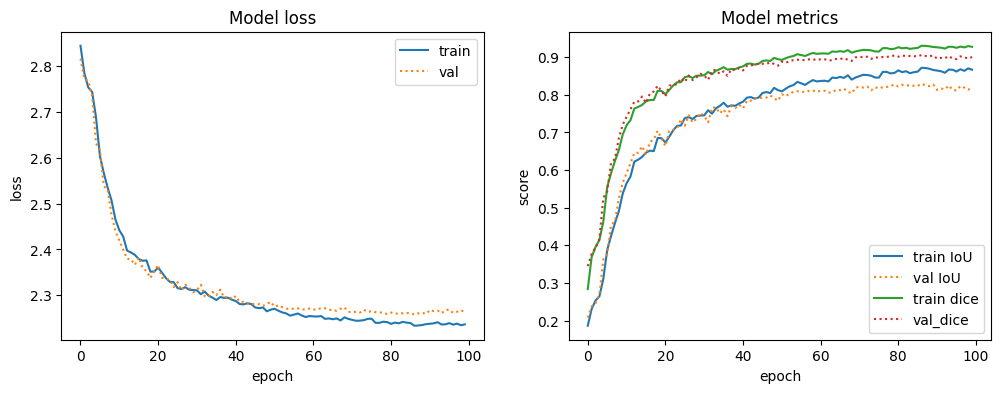

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'], linestyle='dotted')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'], linestyle='dotted')
plt.plot(H['train_DC'])
plt.plot(H['test_DC'], linestyle='dotted')
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [14]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [15]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (0, 0, 0))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

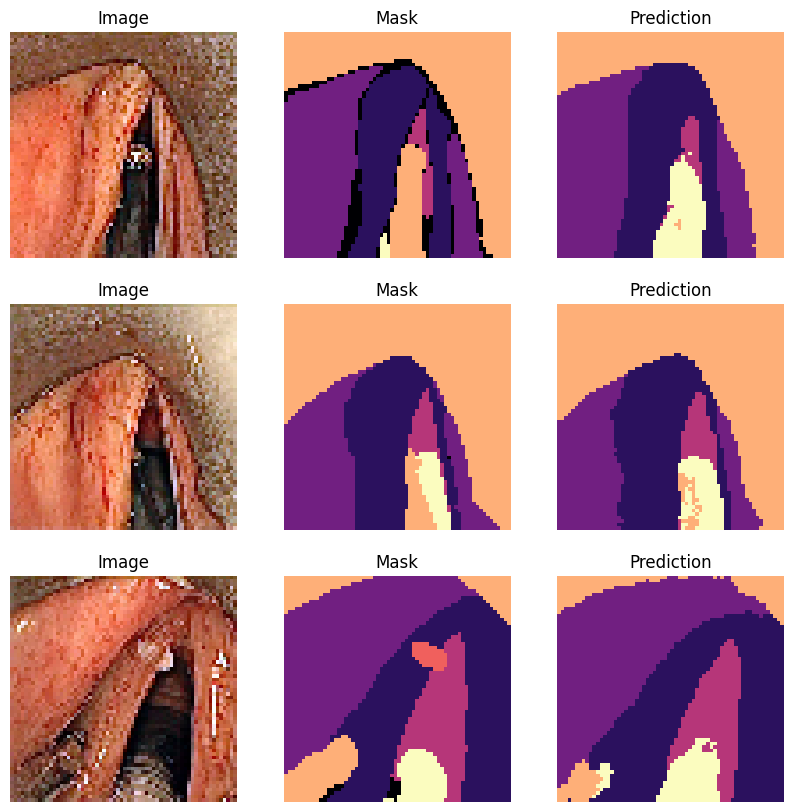

In [16]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=NUM_CLASSES-1))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=NUM_CLASSES-1))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota